In [3]:
%%capture
!pip install "dlt[sql_database, duckdb]"
!pip install pymysql
!pip install pyyaml

# **Performance Optimization in dlt Pipelines**

In this lesson we talk about optimizing the performance of dlt pipelines by analysing and improving the each step within the `pipeline.run()` method

**Steps in `pipeline.run()`**
1. Extract - Fully extracts the data from your source to your hard drive.

2. Normalize
  - Inspects and normalizes your data
  - Computes a schema compatible with your destination this also means unnesting tables to create child tables

3. Load - Runs schema migrations if necessary on your destination and loads your data into the destination

To optimize dlt pipelines - each step has its own optimization techniques

### **When to Optimize dlt Pipelines**

> **`dlt` comes with well-thought-out defaults that work great for most cases.**

The default settings are:
- Conservative enough to work on a laptop.
- Efficient enough to run production loads for many use cases.
- Safe to experiment with incrementally.

**When to start tweaking?**

Once you’ve:
- Run your pipeline end-to-end successfully.
- Noticed slowdowns at scale.
- Understood which part of the pipeline (extract, normalize, load) is the bottleneck.

> **Start with the defaults. Measure. Then tune.**


## **1. Parallelism in Python**
- Python is single threaded by default which means that only 1 operation runs at a time even if there are more cores available.


### **1.1. Threading Library Python**
- Cpython implementation of Python prohibits running python code on more than 1 thread at the same time (this is called the Global Interpreter Lock)
- With the use of libraries like `threading` and `multithreading` you are still using one intrepreter at a time but rapidly switching between them to make it seem parallel, although it is not.
- So technically all we are trying to do is make the most of the wait times by performing other tasks (one thread wait for API response, the other thread while the first one is on standby will read a file)

**When to Use Threading**
-  You should use threading for tasks that usually has to wait a lot, for instance
  - waiting for a website to respond
  - reading or writing a file
  - handling multiple users at the same time
  - So basically I/O bound tasks

In [ ]:
import threading
import time

def boil_water():
    print("Boiling water...")
    time.sleep(3) # simulate wait time
    print("Water boiled!")

def make_toast():
    print("Making toast...")
    time.sleep(2) # simulate wait time
    print("Toast ready!")

# Create threads
# create a thread to execute boil_water()
t1 = threading.Thread(target=boil_water)
# create another thread to execute make_toast()
t2 = threading.Thread(target=make_toast)

# Start them
t1.start() # starts the first thread whihc runs the boil_water() function on the bg
t2.start()

# Wait for both to finish
t1.join()
t2.join()

print("Breakfast done!")


Boiling water...
Making toast...
Toast ready!
Water boiled!
Breakfast done!


In [ ]:
import threading
import time
from concurrent.futures import ThreadPoolExecutor

def threaded_function():
    for number in range(3):
        print(f"Printing from {threading.current_thread().name}. {number=}")
        # Simulate slow API call
        time.sleep(0.1)

with ThreadPoolExecutor(max_workers=4, thread_name_prefix="Worker") as executor:
    for _ in range(4):
        executor.submit(threaded_function)

Printing from Worker_0. number=0
Printing from Worker_1. number=0
Printing from Worker_2. number=0
Printing from Worker_3. number=0
Printing from Worker_0. number=1
Printing from Worker_1. number=1
Printing from Worker_2. number=1
Printing from Worker_3. number=1
Printing from Worker_0. number=2
Printing from Worker_1. number=2
Printing from Worker_2. number=2
Printing from Worker_3. number=2


### **2. Multiprocessing in Python**
- This is the true parallelism in Python where tasks are run concurrently unlike threading
- Multiprocessing is used for calculation intensive applications

In this example, `compute_heavy_task` squares numbers from 0 to 2 and prints the process name it runs on. We use `ProcessPoolExecutor` to run 4 processes in parallel, each computing the task independently.

In [ ]:
import multiprocessing
import time
from concurrent.futures import ProcessPoolExecutor

def compute_heavy_task():
    for number in range(3):
        print(f"Computing in {multiprocessing.current_process().name}. {number=} => {number**2}\n")
        time.sleep(0.1)

if __name__ == "__main__":
  with ProcessPoolExecutor(max_workers=4) as executor:
        for _ in range(4):
            executor.submit(compute_heavy_task)

Computing in ForkProcess-3. number=0 => 0
Computing in ForkProcess-1. number=0 => 0
Computing in ForkProcess-4. number=0 => 0

Computing in ForkProcess-2. number=0 => 0



Computing in ForkProcess-3. number=1 => 1
Computing in ForkProcess-4. number=1 => 1

Computing in ForkProcess-2. number=1 => 1

Computing in ForkProcess-1. number=1 => 1


Computing in ForkProcess-4. number=2 => 4

Computing in ForkProcess-3. number=2 => 4
Computing in ForkProcess-2. number=2 => 4


Computing in ForkProcess-1. number=2 => 4



In [ ]:
import concurrent.futures
import math
import time

# List of large prime numbers
PRIMES = [
    112272535095293,
    112582705942171,
    112272535095293,
    115280095190773,
    115797848077099,
    1099726899285419
]

# Prime-checking function
def is_prime(n):
    if n < 2:
        return False
    if n == 2:
        return True
    if n % 2 == 0:
        return False

    sqrt_n = int(math.floor(math.sqrt(n)))
    for i in range(3, sqrt_n + 1, 2):
        if n % i == 0:
            return False
    return True

# Time the multiprocessing version
start_mp = time.time()
with concurrent.futures.ProcessPoolExecutor() as executor:
    mp_results = list(zip(PRIMES, executor.map(is_prime, PRIMES)))
end_mp = time.time()
mp_duration = end_mp - start_mp

# Time the normal single-threaded version
start_st = time.time()
st_results = [(n, is_prime(n)) for n in PRIMES]
end_st = time.time()
st_duration = end_st - start_st

mp_results, st_results, mp_duration, st_duration

([(112272535095293, True),
  (112582705942171, True),
  (112272535095293, True),
  (115280095190773, True),
  (115797848077099, True),
  (1099726899285419, False)],
 [(112272535095293, True),
  (112582705942171, True),
  (112272535095293, True),
  (115280095190773, True),
  (115797848077099, True),
  (1099726899285419, False)],
 2.247509002685547,
 2.260770797729492)

### **AsyncIO Library in Python**
- It's python lib that provides async iterator in Python
- It is not multithreading nor multiprocessing
- In synchronous programming, tasks are executed one after another. Each task must complete before the next one begins
- Asynchronous programming allows tasks to run concurrently, meaning a program can initiate a task and move on to another without waiting for the first to finish. This is particularly useful for I/O-bound operations.



In [ ]:
import asyncio
import time


async def count():
    print("One")
    await asyncio.sleep(1)
    print("Two")

async def main():
    await asyncio.gather(count(), count(), count())



s = time.perf_counter()

# In Colab, you'll need to get a handle of the current running loop first.
loop = asyncio.get_running_loop()
await loop.create_task(main())

elapsed = time.perf_counter() - s
print(f"executed in {elapsed:0.2f} seconds.")

One
One
One
Two
Two
Two
executed in 1.00 seconds.


## **2. Parallelism in dlt**

## **2.1. Extract Stage Parallelism**
- In the extract stage the files are read and written to intermediary files
- This phase is I/O intensive therefore threading is used

**Default behaviour for Extract Stage**

- The in-memory buffer is set to `5000` items.
- By default, **intermediary files are not rotated**. If you do not explicitly set a size for an intermediary file with `file_max_items=100000`, `dlt` will create a **single file** for a resource, regardless of the number of records it contains, even if it reaches millions.
- By default, intermediary files at the extract stage use a custom version of the JSONL format.

### **2.1.1. Use Larger In-memory Buffer**
- dlt uses buffers when writing intermediary files
- The size of the buffers determines the number of data items held - when the buffer is full it is cleared
- By default, dlt **buffers 5000 items** before writing to disk. Increase this value to reduce disk I/O and improve speed.


**Pros**
- By increasing buffer size you will have fewer writes to intermediary thus saving up on I/O

**Cons**
- Increase a buffer size means an increase in RAM usage which can cause crashes

In [ ]:
import os
import dlt

# when the buffer size is 1, the number of extract workers is effectively limited to 1
os.environ['DATA_WRITER__BUFFER_MAX_ITEMS'] = '1'

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


@dlt.resource()
def buffered_resource():
    for row in get_rows(500000):
        yield row

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline1", destination="duckdb", dataset_name="mydata", dev_mode=True,
)
load_info = pipeline.extract(buffered_resource)
print(pipeline.last_trace)

Run started at 2025-05-05 14:15:32.754999+00:00 and COMPLETED in 9.39 seconds with 1 steps.
Step extract COMPLETED in 9.38 seconds.

Load package 1746454532.76826 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


In [ ]:
import os
import dlt

# number of buffer items increased
os.environ['DATA_WRITER__BUFFER_MAX_ITEMS'] = '5000'

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


@dlt.resource()
def buffered_resource():
    for row in get_rows(500000):
        yield row

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline2", destination="duckdb", dataset_name="mydata", dev_mode=True,
)
load_info = pipeline.extract(buffered_resource)
print(pipeline.last_trace)

Run started at 2025-05-05 14:15:56.700969+00:00 and COMPLETED in 6.87 seconds with 1 steps.
Step extract COMPLETED in 6.87 seconds.

Load package 1746454556.7122946 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


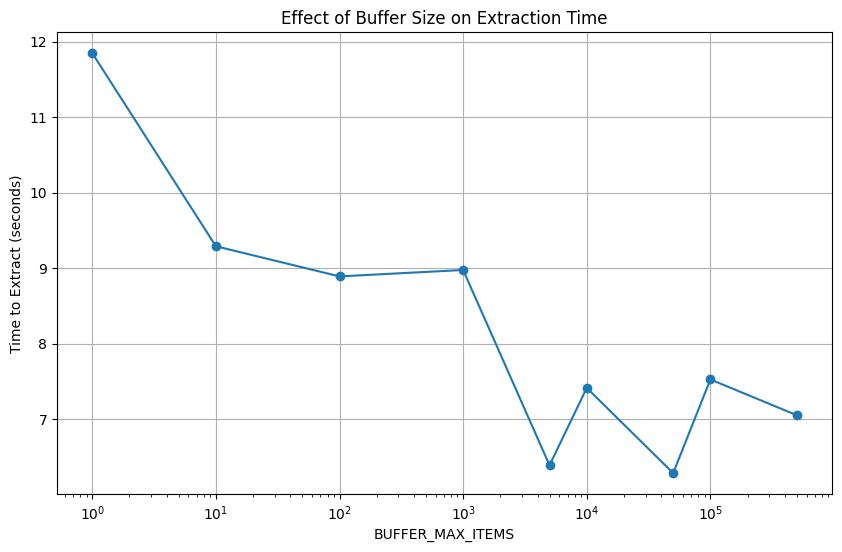

In [ ]:
import os
import time
import dlt
import matplotlib.pyplot as plt


def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


def measure_extract_time(buffer_size):
    os.environ['DATA_WRITER__BUFFER_MAX_ITEMS'] = str(buffer_size)

    @dlt.resource()
    def buffered_resource():
        for row in get_rows(500000):
            yield row

    pipeline = dlt.pipeline(
        pipeline_name=f"extract_pipeline_{buffer_size}",
        destination="duckdb",
        dataset_name="mydata",
        dev_mode=True,
    )

    start_time = time.time()
    pipeline.extract(buffered_resource)
    return time.time() - start_time


# Try different buffer sizes
buffer_sizes = [1, 10, 100, 1000, 5000, 10000, 50000, 100000, 500000]
times = [measure_extract_time(size) for size in buffer_sizes]


plt.figure(figsize=(10, 6))
plt.plot(buffer_sizes, times, marker='o')
plt.xlabel('BUFFER_MAX_ITEMS')
plt.ylabel('Time to Extract (seconds)')
plt.title('Effect of Buffer Size on Extraction Time')
plt.grid(True)
plt.xscale('log')
plt.show()

### **2.1.2. Group Resources into Sources**
- Each resource in dlt is treated as a separate execution unit, which means if you pass multiple resources on pipeline.run() then each will have it's own context and process
- Grouping resources in sources has the following benefits
  - dlt can reuse context for different resources like database connections or API
  - provides better manageability
  - enables better parallelism
  - dlt can schedule their extraction in the same shared thread pool

In [ ]:
import os
import dlt

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))

@dlt.resource(name="resource1")
def buffered_resource1():
    for row in get_rows(500000):
        yield row


@dlt.resource(name="resource2")
def buffered_resource2():
    for row in get_rows(500000):
        yield row


@dlt.resource(name="resource3")
def buffered_resource3():
    for row in get_rows(500000):
        yield row



pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

# extract data without grouping resources
load_info = pipeline.extract([buffered_resource1, buffered_resource2, buffered_resource3])
print(pipeline.last_trace)

Run started at 2025-05-05 14:24:07.240791+00:00 and COMPLETED in 29.49 seconds with 1 steps.
Step extract COMPLETED in 29.49 seconds.

Load package 1746455047.2520053 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


In [ ]:
import os
import time
import dlt
from threading import currentThread

# resources grouped
@dlt.source
def source():
  return buffered_resource1, buffered_resource2, buffered_resource3


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.extract(source())
print(pipeline.last_trace)

Run started at 2025-05-05 14:24:36.930711+00:00 and COMPLETED in 21.85 seconds with 1 steps.
Step extract COMPLETED in 21.85 seconds.

Load package 1746455076.9422636 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


### **2.1.3. Enable parallel threaded extraction**

When extracting data from **multiple sources**, you usually want them to be processed **at the same time**, not one after another. This is especially useful when:

- Calling **slow APIs**
- Working with **multiple endpoints**
- Extracting from **databases with many tables**

Use multiple threads to fetch data from different resources with `parallelized=True`.


**Simulate Slow APIs with `time.sleep`**

We’ll simulate API latency by adding a `time.sleep(0.01)` delay before yielding each row. This mimics a network call taking ~10ms.

We’ll then parallelize the resources using `parallelized=True` and observe the thread behavior using `threading.currentThread()`.


In [2]:
import os
import dlt
import time
from threading import current_thread

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))

# Resource 1: slow generator, runs in a separate thread
@dlt.resource(name="resource1", parallelized=False)
def buffered_resource1():
    for row in get_rows(100):
        time.sleep(0.01)  # Simulate slow API call
        print(f"resource1 in thread {current_thread().name}")
        yield row


@dlt.resource(name="resource2", parallelized=False)
def buffered_resource2():
    for row in get_rows(100):
        time.sleep(0.01)
        print(f"resource2 in thread {current_thread().name}")
        yield row


@dlt.resource(name="resource3", parallelized=False)
def buffered_resource3():
    for row in get_rows(100):
        time.sleep(0.01)
        print(f"resource3 in thread {current_thread().name}")
        yield row


@dlt.source
def source():
    return buffered_resource1, buffered_resource2, buffered_resource3


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


load_info = pipeline.extract(source())
print(pipeline.last_trace)

resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource3 in thread MainThread
resource1 in thread MainThread
resource2 in thread MainThread
resource

**What Happened in the above code?**
- dlt is extracting rows from the resources in a round robin fashion (one row from each resource) and within the `MainThread`
- Parallelism is not enabled therefore the resources are executed sequentially


**Let's Enable Parallelism**
- Add `parallelized=True` to each resource — allowing `dlt` to extract from all three **at the same time**, using separate threads.

In [3]:
import os
import dlt
import time
from threading import current_thread

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


# Resource 1: slow generator, runs in a separate thread
@dlt.resource(name="resource1", parallelized=True)
def buffered_resource1():
    for row in get_rows(100):
        time.sleep(0.01)  # Simulate slow API call
        print(f"resource1 in thread {current_thread().name}")
        yield row


@dlt.resource(name="resource2", parallelized=True)
def buffered_resource2():
    for row in get_rows(100):
        time.sleep(0.01)
        print(f"resource2 in thread {current_thread().name}")
        yield row


@dlt.resource(name="resource3", parallelized=True)
def buffered_resource3():
    for row in get_rows(100):
        time.sleep(0.01)
        print(f"resource3 in thread {current_thread().name}")
        yield row


@dlt.source
def source():
    return buffered_resource1, buffered_resource2, buffered_resource3


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


load_info = pipeline.extract(source())
print(pipeline.last_trace)

resource1 in thread dlt-pool-135345135198208-threads_0
resource2 in thread dlt-pool-135345135198208-threads_1
resource3 in thread dlt-pool-135345135198208-threads_2
resource2 in thread dlt-pool-135345135198208-threads_0
resource3 in thread dlt-pool-135345135198208-threads_1
resource1 in thread dlt-pool-135345135198208-threads_2
resource1 in thread dlt-pool-135345135198208-threads_0
resource3 in thread dlt-pool-135345135198208-threads_2
resource2 in thread dlt-pool-135345135198208-threads_1
resource3 in thread dlt-pool-135345135198208-threads_0
resource2 in thread dlt-pool-135345135198208-threads_1
resource1 in thread dlt-pool-135345135198208-threads_2
resource3 in thread dlt-pool-135345135198208-threads_1
resource2 in thread dlt-pool-135345135198208-threads_0
resource1 in thread dlt-pool-135345135198208-threads_2
resource1 in thread dlt-pool-135345135198208-threads_1
resource3 in thread dlt-pool-135345135198208-threads_2
resource2 in thread dlt-pool-135345135198208-threads_0
resource1 

The example below does the same but using an async generator as the main resource and async/await and futures pool for the transformer.

**Example 1 — Synchronous execution (sequential, slow)**

In [4]:
import time
import dlt

@dlt.resource
def sync_items():
    for i in range(10):
        time.sleep(0.5)  # Blocking call
        yield i


@dlt.transformer
def sync_transform(item):
    time.sleep(0.5)  # Also blocking
    return {"row": item}


start = time.time()
result = list(sync_items() | sync_transform)
print(f"Sync result: {result}")
print("Sync elapsed time:", round(time.time() - start, 2), "seconds")


Sync result: [{'row': 0}, {'row': 1}, {'row': 2}, {'row': 3}, {'row': 4}, {'row': 5}, {'row': 6}, {'row': 7}, {'row': 8}, {'row': 9}]
Sync elapsed time: 10.02 seconds


**Example 2 — Asynchronous execution (concurrent, fast)**

In [5]:
import asyncio
import time
import dlt

@dlt.resource
async def async_items():
    for i in range(10):
        await asyncio.sleep(0.5)  # Blocking
        yield i


@dlt.transformer
async def async_transform(item):
    await asyncio.sleep(0.5)  # Non-blocking
    # just return the results, if you yield, generator will be evaluated in main thread
    return {"row": item}


start = time.time()
print(list(async_items() | async_transform))
print("Async elapsed time:", round(time.time() - start, 2), "seconds")

[{'row': 0}, {'row': 1}, {'row': 2}, {'row': 3}, {'row': 4}, {'row': 5}, {'row': 6}, {'row': 7}, {'row': 8}, {'row': 9}]
Async elapsed time: 5.54 seconds


### **2.1.4. Yielding Chunks of Rows**
- When dealing with APIs, they usually return data in *pages*, with each page containing some number of rows
- Yield the whole page itself instead of rows

In [6]:
import os
import dlt
import time
from threading import current_thread
from itertools import islice

def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


def yield_chunks(iterable, chunk_size=10):
    iterator = iter(iterable)
    while chunk := list(islice(iterator, chunk_size)):  # <--- we slice data into chunks
        time.sleep(0.01)  # Simulate slow API call
        yield chunk


# Chunked resources, run in parallel threads
@dlt.resource(name="resource1", parallelized=True)
def buffered_resource1():
    yield from yield_chunks(get_rows(100), chunk_size=10)


@dlt.resource(name="resource2", parallelized=True)
def buffered_resource2():
    yield from yield_chunks(get_rows(100), chunk_size=10)


@dlt.resource(name="resource3", parallelized=True)
def buffered_resource3():
    yield from yield_chunks(get_rows(100), chunk_size=10)


@dlt.source
def source():
    return buffered_resource1, buffered_resource2, buffered_resource3


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline4",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.extract(source())
print(pipeline.last_trace)

Run started at 2025-05-06 12:27:28.440056+00:00 and COMPLETED in 0.22 seconds with 1 steps.
Step extract COMPLETED in 0.22 seconds.

Load package 1746534448.4515538 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


### **2.1.5. Enable File Rotation for Large Datasets**
- File Rotation basically means that instead of creating 1 big intermediary file that will be loaded to the destination create multiple slightly smaller files

- You can **enable file rotation** by setting a file size limit. For example:

```python
os.environ["EXTRACT__DATA_WRITER__FILE_MAX_ITEMS"] = "100000"
```

This means:
- Every 100,000 items, a new intermediary file will be created
- If you have 1,000,000 rows, you'll end up with 10 files
- Later, these files can be processed **in parallel** during normalization and load

File rotation is essential for scaling up performance when dealing with large datasets.



## **2.2. Normalize Stage Parallelism**

Normalize Process
1. Extracted files are passed to Normalize Process pool
2. Each file is read, schema is resolved and data is transformed
3. Rows are buffered and written to normalized intermediary files which are used for loading later


**Default behavior**

- **Buffer size**: 5,000 items
- **Parallelism**: Off by default (runs in main process)
- **File rotation**: Off by default — all rows written into one file
- **Compression**: On by default

**Normalization Bottlenecks**
Normalization is a CPU intensive process, without parallelism large files can become bottlenecks

Following sections will cover some techniques to optimize Normalization performance

### **2.2.1. Enable Parallelism**

You can increase the number of Normalization workers, by default it is 1
```python
   os.environ['NORMALIZE__WORKERS'] = '3'
```

In [7]:
# example with default settings
import os
import dlt
import time
from threading import current_thread
from itertools import islice


def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


def yield_chunks(iterable, chunk_size=10):
    iterator = iter(iterable)
    while chunk := list(islice(iterator, chunk_size)):  # <--- we slice data into chunks
        time.sleep(0.01)  # Simulate slow API call
        yield chunk


# Chunked resources, run in parallel threads
@dlt.resource(name="resource1", parallelized=True)
def buffered_resource1():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)


@dlt.resource(name="resource2", parallelized=True)
def buffered_resource2():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)


@dlt.source
def source():
    return buffered_resource1, buffered_resource2


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_w1",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.extract(source())
print(pipeline.last_trace)


Run started at 2025-05-06 12:45:36.997635+00:00 and COMPLETED in 2.77 seconds with 1 steps.
Step extract COMPLETED in 2.77 seconds.

Load package 1746535537.023292 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs


In [8]:
import os
import time

os.environ['NORMALIZE__WORKERS'] = '1'

load_info = pipeline.normalize()
print(pipeline.last_trace)

Run started at 2025-05-06 12:45:36.997635+00:00 and COMPLETED in 1 minute and 16.71 seconds with 2 steps.
Step extract COMPLETED in 2.77 seconds.

Load package 1746535537.023292 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 56.62 seconds.
Normalized data for the following tables:
- resource2: 1000000 row(s)
- _dlt_pipeline_state: 1 row(s)
- resource1: 1000000 row(s)

Load package 1746535537.023292 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs


In [9]:
import os
os.cpu_count()

2

In [10]:
# Set the number of process workers to 2
os.environ['NORMALIZE__WORKERS'] = '2'

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_w2",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


load_info = pipeline.extract(source())
load_info = pipeline.normalize()

print(pipeline.last_trace)

Run started at 2025-05-06 12:47:15.362159+00:00 and COMPLETED in 58.09 seconds with 2 steps.
Step extract COMPLETED in 3.38 seconds.

Load package 1746535635.3731623 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 54.70 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- resource1: 1000000 row(s)
- resource2: 1000000 row(s)

Load package 1746535635.3731623 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs


### **2.2.2. Enable File Rotation for Large Datasets**

By default, all normalized data goes into **one big file** — which means **only one process** can handle it. That kills parallelism.

To change that setting you can set:

```python
os.environ["NORMALIZE__DATA_WRITER__FILE_MAX_ITEMS"] = "100000"
```

Now `dlt` will:
- Split data into smaller files (e.g., 10 files for 1M rows)
- Load them **in parallel** using multiple workers
- Speed up loading


### **2.2.3. Disable Compression or Increase Buffer Size**

**Disable compression (for debugging or speed)**
  ```python
  os.environ['NORMALIZE_DATA_WRITER__DISABLE_COMPRESSION'] = 'true'
  ```

**Control buffer size**
```python
os.environ['NORMALIZE__DATA_WRITER__BUFFER_MAX_ITEMS'] = '10000'
```


## **2.3. Load Stage Parallelism**

This stage uses a **thread pool**, where:
1. Each thread loads one normalized file at a time.
2. Files from the same source are bundled into a **load package**.
3. Packages are loaded into the destination concurrently.

**Default behavior**

- `dlt` uses **20 threads** by default
- Each thread processes one file
- All file contents are already normalized — there’s no parsing or schema detection at this point, so it’s mostly **I/O-bound**

### **2.3.1. How to optimize loading?**


1. **Control the number of threads**  
   Set this based on your destination’s capacity:

   ```python
   os.environ["LOAD__WORKERS"] = "4"
   ```

2. **Rotate files during normalization**  
   If all your data is in **one big file**, you’ll still have only **one load job**. To unlock real parallelism:
   ```python
   os.environ["NORMALIZE__DATA_WRITER__FILE_MAX_ITEMS"] = "100000"
   ```


In [11]:
# example using only 1 thread for loading
import os
import dlt
import time
from threading import current_thread
from itertools import islice


def get_rows(limit):
    yield from map(lambda n: {"row": n}, range(limit))


def yield_chunks(iterable, chunk_size=10):
    iterator = iter(iterable)
    while chunk := list(islice(iterator, chunk_size)):  # <--- we slice data into chunks
        time.sleep(0.01)  # Simulate slow API call
        yield chunk


# Chunked resources, run in parallel threads
@dlt.resource(name="resource1", parallelized=True)
def buffered_resource1():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)


@dlt.resource(name="resource2", parallelized=True)
def buffered_resource2():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)



@dlt.resource(name="resource3", parallelized=True)
def buffered_resource3():
    yield from yield_chunks(get_rows(1000000), chunk_size=10000)


@dlt.source
def source():
    return buffered_resource1, buffered_resource2, buffered_resource3

# Set the number of thread workers to 1
os.environ['LOAD__WORKERS'] = '1'

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_load1",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


pipeline.extract(source())
pipeline.normalize()
pipeline.load()


print(pipeline.last_trace)

Run started at 2025-05-06 12:56:23.217997+00:00 and COMPLETED in 3 minutes and 27.38 seconds with 3 steps.
Step extract COMPLETED in 3.70 seconds.

Load package 1746536183.2282429 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 1 minute and 16.07 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- resource1: 1000000 row(s)
- resource2: 1000000 row(s)
- resource3: 1000000 row(s)

Load package 1746536183.2282429 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 2 minutes and 7.61 seconds.
Pipeline extract_pipeline_load1 load step completed in 2 minutes and 6.45 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata_20250506125623
The duckdb destination used duckdb:////content/extract_pipeline_load1.duckdb location to store data
Load package 1746536183.2282429 is LOADED and contains no failed jobs


In [ ]:
# Okay lets try to increase the number of threads - Set the number of thread workers to 3
os.environ['LOAD__WORKERS'] = '3'

pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_load2",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)


pipeline.extract(source())
pipeline.normalize()
pipeline.load()


print(pipeline.last_trace)

2025-05-06 13:04:26,424|[WARNING]|481|135345135198208|dlt|pool_runner.py|run_pool:99|Exiting runner due to signal 2


In [ ]:
exit()

## **3. Optimization Example**
we'll optimize a pipeline that loads data from seven different GitHub endpoints.

In [6]:
# optimization 1 - yield pages/chunks of data instead of row

import dlt
import time
import requests
from google.colab import userdata


github_token = userdata.get('SECRET_KEY')

headers = {
    "Authorization": f"token {github_token}"
}

def pagination(url):
    while True:
        response = requests.get(url, headers=headers)
        time.sleep(0.1)               # Simulate delay
        response.raise_for_status()
        yield response.json()         # Here we're yielding pages

        # Get next page
        if "next" not in response.links:
            break
        url = response.links["next"]["url"]


@dlt.resource(table_name="issues", write_disposition="merge", primary_key="id")
def get_issues(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        f"https://api.github.com/repos/dlt-hub/dlt/issues?since={updated_at.last_value}&per_page=100sort=updated"
    )
    yield pagination(url)


@dlt.resource(table_name="stargazers", write_disposition="merge", primary_key="id")
def get_stargazers():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/stargazers?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="pull_requests", write_disposition="merge", primary_key="id")
def get_pulls(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        f"https://api.github.com/repos/dlt-hub/dlt/pulls?since={updated_at.last_value}&per_page=100&sort=updated"
    )
    yield pagination(url)

@dlt.resource(table_name="commits", write_disposition="merge", primary_key="sha")
def get_commits():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/commits?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="branches", write_disposition="merge", primary_key="name")
def get_branches():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/branches?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="contributors", write_disposition="merge", primary_key="id")
def get_contributors():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/contributors?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="labels", write_disposition="merge", primary_key="id")
def get_labels():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/labels?per_page=100"
    )
    yield pagination(url)

In [7]:
pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_example1",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.run([get_issues, get_stargazers, get_pulls, get_branches, get_contributors, get_labels, get_commits])

In [8]:
import os

os.environ['EXTRACT__WORKERS'] = '7'
os.environ['NORMALIZE__WORKERS'] = '2'

import time

@dlt.resource(table_name="issues", write_disposition="merge", primary_key="id", parallelized=True)
def get_issues_2(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        f"https://api.github.com/repos/dlt-hub/dlt/issues?since={updated_at.last_value}&per_page=100sort=updated"
    )
    yield pagination(url)


@dlt.resource(table_name="stargazers", write_disposition="merge", primary_key="id", parallelized=True)
def get_stargazers_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/stargazers?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="pull_requests", write_disposition="merge", primary_key="id", parallelized=True)
def get_pulls_2(
    updated_at=dlt.sources.incremental("updated_at", initial_value="1970-01-01T00:00:00Z")
):
    url = (
        f"https://api.github.com/repos/dlt-hub/dlt/pulls?since={updated_at.last_value}&per_page=100&sort=updated"
    )
    yield pagination(url)


@dlt.resource(table_name="commits", write_disposition="merge", primary_key="sha", parallelized=True)
def get_commits_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/commits?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="branches", write_disposition="merge", primary_key="name", parallelized=True)
def get_branches_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/branches?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="contributors", write_disposition="merge", primary_key="id", parallelized=True)
def get_contributors_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/contributors?per_page=100"
    )
    yield pagination(url)


@dlt.resource(table_name="labels", write_disposition="merge", primary_key="id", parallelized=True)
def get_labels_2():
    url = (
        "https://api.github.com/repos/dlt-hub/dlt/labels?per_page=100"
    )
    yield pagination(url)


@dlt.source
def github_data():
    return get_issues_2, get_stargazers_2, get_pulls_2, get_branches_2, get_contributors_2, get_labels_2, get_commits_2

improved_p = dlt.pipeline(
    "test_pipeline_2",
    destination="duckdb"
)


pipeline = dlt.pipeline(
    pipeline_name="extract_pipeline_example2",
    destination="duckdb",
    dataset_name="mydata",
    dev_mode=True,
)

load_info = pipeline.run(github_data())
print(pipeline.last_trace)

Run started at 2025-05-06 13:20:03.989169+00:00 and COMPLETED in 1 minute and 9.86 seconds with 4 steps.
Step extract COMPLETED in 56.59 seconds.

Load package 1746537604.0458207 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 3.13 seconds.
Normalized data for the following tables:
- contributors: 102 row(s)
- labels: 22 row(s)
- pull_requests: 34 row(s)
- pull_requests__assignees: 32 row(s)
- pull_requests__requested_reviewers: 14 row(s)
- pull_requests__labels: 16 row(s)
- pull_requests__head__repo__topics: 240 row(s)
- pull_requests__base__repo__topics: 340 row(s)
- stargazers: 3558 row(s)
- _dlt_pipeline_state: 1 row(s)
- branches: 65 row(s)
- commits: 3610 row(s)
- commits__parents: 4052 row(s)

Load package 1746537604.0458207 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 10.12 seconds.
Pipeline extract_pipeline_example2 load step completed in 10.08 seconds
1 load 